#Kaggle | Rain in Australia
##Predicción de lluvía el día siguiente

### Proyecto
Se pretende realizar la predicción de lluvia del día siguiente en base a los datos meteorológicos de Australia ofrecidos utilizando modelos de machine learning.

### Dataset
El dataset contiene observaciones del tiempo en diversos puntos de Australia a lo largo de 10 años. En este caso son dos datasets obtenidos, uno de entrenamiento y otro de test.

El dataset puede ser obtenido en el siguiente enlace: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

----

## Paquetería y dataset


In [54]:
!pip install nevergrad

     |████████████████████████████████| 411 kB 5.2 MB/s 
     |████████████████████████████████| 269 kB 45.5 MB/s 
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=319f2732197ac2c055fd929c1bae19d9c9fdc4580d59808da1af6c3549fa8f2e
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

import nevergrad as ng
from imblearn.over_sampling import SMOTENC

from sklearn import metrics
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif

from keras import backend as K

from keras.utils.generic_utils import get_custom_objects
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_path = 'train.csv'
test_path = 'test.csv'

In [3]:
df = pd.read_csv(train_path)
df2 = pd.read_csv(test_path)

In [4]:
df

,id,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,100511,2011-09-25,MountGambier,2.5,16.1,2.4,2.4,8.7,SE,37.0,ESE,E,20.0,19.0,54.0,48.0,1026.3,1022.8,1.0,3.0,12.5,15.5,Yes,No
1,107590,2014-10-19,Woomera,16.4,35.5,0.0,37.6,NaN,N,43.0,NNE,N,26.0,20.0,6.0,1.0,1020.6,1018.0,0.0,4.0,24.7,34.4,No,No
2,43808,2012-06-14,Wollongong,11.4,17.0,10.8,NaN,NaN,NW,28.0,SSW,NE,15.0,9.0,94.0,81.0,1019.9,1016.2,8.0,NaN,13.8,16.2,Yes,No
3,62101,2011-08-08,Sale,4.3,12.3,0.2,1.8,1.2,W,20.0,W,W,9.0,11.0,90.0,74.0,1011.3,1009.3,7.0,7.0,8.8,11.4,No,Yes
4,22518,2012-11-30,NorfolkIsland,18.3,23.2,0.0,5.0,11.2,ESE,31.0,SSW,SE,20.0,19.0,75.0,71.0,1017.0,1016.8,6.0,4.0,21.5,21.9,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55434,50362,2012-09-01,Tuggeranong,-5.5,13.5,1.4,NaN,NaN,SE,41.0,W,SE,2.0,24.0,73.0,41.0,1023.1,1021.6,NaN,NaN,3.0,13.0,Yes,No
55435,81024,2009-01-27,Dartmoor,NaN,NaN,NaN,6.6,13.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55436,88192,2011-09-19,Cairns,17.8,29.4,0.0,8.0,10.8,ESE,37.0,S,E,17.0,24.0,56.0,44.0,1018.4,1014.1,1.0,1.0,24.8,27.6,No,No
55437,138724,2016-06-04,AliceSprings,6.4,18.0,0.2,NaN,NaN,ENE,19.0,NaN,E,0.0,9.0,97.0,51.0,1020.8,1016.8,8.0,NaN,9.1,16.8,No,No


# EDA
Pasamos a ver que características tiene los datos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55439 entries, 0 to 55438
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             55439 non-null  int64  
 1   Date           55439 non-null  object 
 2   Location       55439 non-null  object 
 3   MinTemp        54858 non-null  float64
 4   MaxTemp        54954 non-null  float64
 5   Rainfall       54184 non-null  float64
 6   Evaporation    31700 non-null  float64
 7   Sunshine       28962 non-null  float64
 8   WindGustDir    51481 non-null  object 
 9   WindGustSpeed  51498 non-null  float64
 10  WindDir9am     51411 non-null  object 
 11  WindDir3pm     53755 non-null  object 
 12  WindSpeed9am   54723 non-null  float64
 13  WindSpeed3pm   54205 non-null  float64
 14  Humidity9am    54404 non-null  float64
 15  Humidity3pm    53694 non-null  float64
 16  Pressure9am    49658 non-null  float64
 17  Pressure3pm    49663 non-null  float64
 18  Cloud9

In [6]:
df.describe()

,id,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,55439.000000,54858.000000,54954.000000,54184.000000,31700.000000,28962.000000,51498.000000,54723.000000,54205.000000,54404.000000,53694.000000,49658.000000,49663.000000,34262.000000,32947.000000,54732.000000,54035.000000
mean,72602.309872,12.155824,23.187508,2.345539,5.475435,7.604661,40.050235,14.056101,18.661544,68.912323,51.566916,1017.664479,1015.274548,4.461152,4.506146,16.951876,21.663500
std,41907.189308,6.410919,7.131604,8.472157,4.240333,3.786180,13.577121,8.949570,8.793586,19.002683,20.838585,7.091669,7.013259,2.886668,2.719474,6.491382,6.960858
min,0.000000,-8.500000,-3.800000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,980.500000,979.000000,0.000000,0.000000,-7.000000,-3.900000
25%,36339.000000,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.000000,1010.500000,1.000000,2.000000,12.300000,16.600000
50%,72498.000000,12.000000,22.600000,0.000000,4.600000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,108684.500000,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,145458.000000,31.900000,48.100000,371.000000,86.200000,14.300000,135.000000,130.000000,72.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,8.000000,40.200000,46.200000


In [7]:
df.describe(include='object')

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,55439,55439,51481,51411,53755,54183,54167
unique,3320,49,16,16,16,2,2
top,2016-03-19,Canberra,W,N,SE,No,No
freq,30,1331,3783,4495,4133,42079,42063


In [8]:
df.groupby(['Location'])['Location'].count().sort_values()

Location
Katherine            579
Uluru                583
Nhil                 609
Wollongong          1103
Dartmoor            1104
PerthAirport        1104
PearceRAAF          1105
SalmonGums          1105
BadgerysCreek       1108
Williamtown         1118
SydneyAirport       1121
NorahHead           1127
Witchcliffe         1129
Ballarat            1129
GoldCoast           1129
NorfolkIsland       1134
Portland            1135
Launceston          1138
Walpole             1144
Richmond            1148
Penrith             1148
Nuriootpa           1150
AliceSprings        1152
Cobar               1154
Tuggeranong         1158
Mildura             1159
WaggaWagga          1159
Albury              1161
Newcastle           1163
Watsonia            1167
Cairns              1169
MelbourneAirport    1170
Bendigo             1173
Sale                1188
Woomera             1190
Moree               1191
Darwin              1191
Townsville          1192
Brisbane            1194
Albany          

Número de NaN por columnas


In [9]:
df.isna().sum()

id                   0
Date                 0
Location             0
MinTemp            581
MaxTemp            485
Rainfall          1255
Evaporation      23739
Sunshine         26477
WindGustDir       3958
WindGustSpeed     3941
WindDir9am        4028
WindDir3pm        1684
WindSpeed9am       716
WindSpeed3pm      1234
Humidity9am       1035
Humidity3pm       1745
Pressure9am       5781
Pressure3pm       5776
Cloud9am         21177
Cloud3pm         22492
Temp9am            707
Temp3pm           1404
RainToday         1256
RainTomorrow      1272
dtype: int64

Número de NaN por filas


In [10]:
df.isna().sum(axis=1).value_counts().sort_index()

0     21737
1      4074
2      6995
3      3730
4     10731
5      1558
6      3871
7       856
8       430
9       208
10      149
11      262
12      334
13      236
14       32
15       29
16       21
17       49
18       18
19       36
20        6
21       77
dtype: int64

Distribución del dataset en función de la columna  'RainTomorrow'

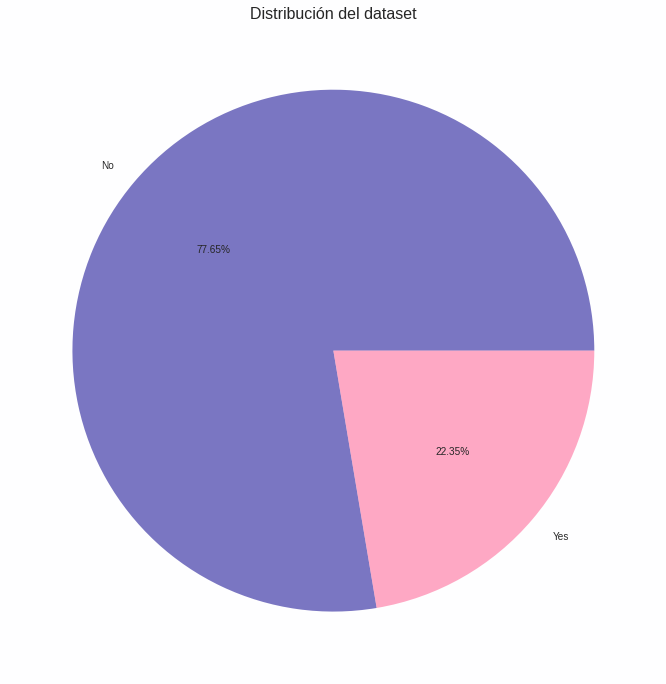

In [11]:
index_count = df['RainTomorrow'].value_counts().index
values = df['RainTomorrow'].value_counts().values

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

fig, ax = plt.subplots(figsize=(14,12))
ax.pie(values, labels = index_count, autopct='%1.2f%%')
ax.set_title('Distribución del dataset', fontsize=16)
plt.show()

Distribución del número de NAn por filas en el dataset



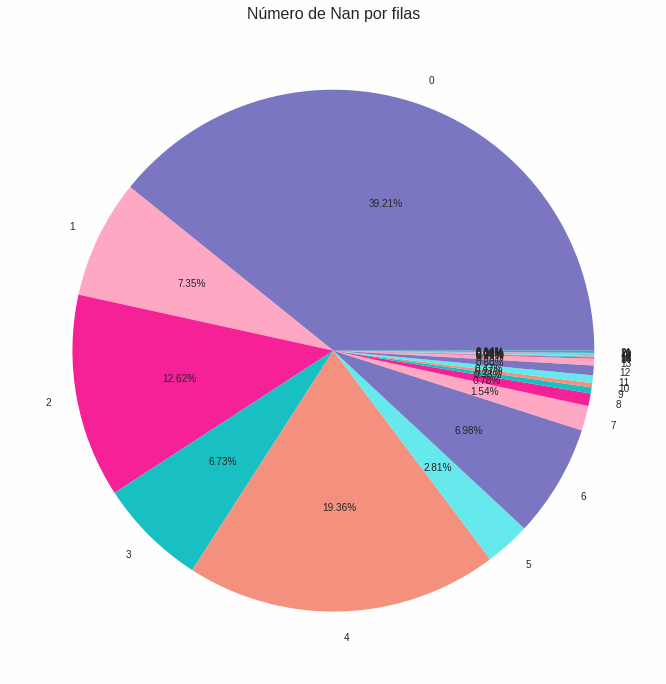

In [12]:
index_count = df.isna().sum(axis=1).value_counts().sort_index().index
nan_values = df.isna().sum(axis=1).value_counts().sort_index().values

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

fig, ax = plt.subplots(figsize=(14,12))
ax.pie(nan_values, labels = index_count, autopct='%1.2f%%')
ax.set_title('Número de Nan por filas', fontsize=16)
plt.show()

# Feature engineering

Eliminamos las filas que tengan mas de 6 NaN

In [13]:
nonNA = df.shape[1] - 6
df = df.dropna(thresh = nonNA)

In [14]:
df.isna().sum(axis=1).value_counts().sort_index()

0    21737
1     4074
2     6995
3     3730
4    10731
5     1558
6     3871
dtype: int64

Nueva distribución del número de NAn por filas en el dataset tras la eliminación.


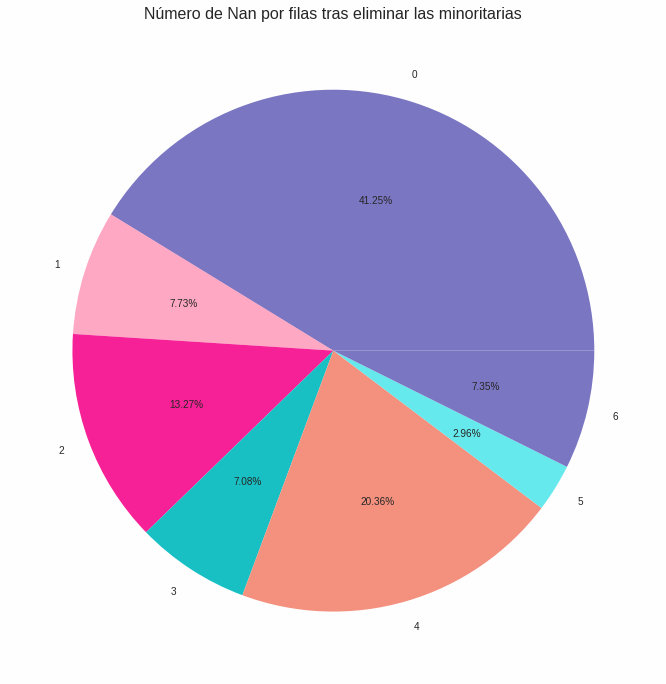

In [15]:
index_count = df.isna().sum(axis=1).value_counts().sort_index().index
nan_values = df.isna().sum(axis=1).value_counts().sort_index().values

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

fig, ax = plt.subplots(figsize=(14,12))
ax.pie(nan_values, labels = index_count, autopct='%1.2f%%')
ax.set_title('Número de Nan por filas tras eliminar las minoritarias', fontsize=16)
plt.show()

Dimensiones del dataset

In [16]:
df.shape

(52696, 24)

Conversión de las fechas en formato día, mes y año

In [17]:
df['Date'] = df['Date'].apply(pd.to_datetime)
df2['Date'] = df2['Date'].apply(pd.to_datetime)

In [18]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

df2['year'] = df2['Date'].dt.year
df2['month'] = df2['Date'].dt.month
df2['day'] = df2['Date'].dt.day

In [19]:
df[['Date','year','month','day']]

,Date,year,month,day
0,2011-09-25,2011,9,25
1,2014-10-19,2014,10,19
2,2012-06-14,2012,6,14
3,2011-08-08,2011,8,8
4,2012-11-30,2012,11,30
...,...,...,...,...
55432,2012-04-22,2012,4,22
55433,2010-03-23,2010,3,23
55434,2012-09-01,2012,9,1
55436,2011-09-19,2011,9,19


In [20]:
df.drop(['Date'], axis=1, inplace=True)
df2.drop(['Date'], axis=1, inplace=True)

Conversión del lugar en coordenadas geográficas

In [21]:
location_list = df['Location'].unique().tolist()

Se usa una API para la conversión del lugar en coordenadas.

In [22]:
dict_geocoding = {}

for location in location_list:
    r = requests.get('http://api.positionstack.com/v1/forward' \
                    '?access_key=3c6666a6928e44d3da860703e417d264' \
                    f'&query={location}' \
                    '&country=AU')
    
    dict_geocoding[location]=r.json()['data']

In [23]:
empty_geocoding = []
geocoding ={}

for key, value in dict_geocoding.items():
    if not value:
        empty_geocoding.append(key)
    else:
        geocoding[key] = {'latitude': value[0]['latitude'], 'longitude': value[0]['longitude']}

In [24]:
geocoding

{'Adelaide': {'latitude': -34.929075, 'longitude': 138.602578},
 'Albany': {'latitude': -35.031075, 'longitude': 117.89494},
 'Albury': {'latitude': -36.074771, 'longitude': 146.914504},
 'Ballarat': {'latitude': -37.563892, 'longitude': 143.852395},
 'Bendigo': {'latitude': -36.757608, 'longitude': 144.27957},
 'Brisbane': {'latitude': -27.469309, 'longitude': 153.026164},
 'Cairns': {'latitude': -16.922929, 'longitude': 145.775689},
 'Canberra': {'latitude': -35.470057, 'longitude': 148.954507},
 'Cobar': {'latitude': -31.497282, 'longitude': 145.834345},
 'Dartmoor': {'latitude': -37.919626, 'longitude': 141.278023},
 'Darwin': {'latitude': -12.460477, 'longitude': 130.842984},
 'Hobart': {'latitude': -42.882256, 'longitude': 147.325986},
 'Katherine': {'latitude': -14.453207, 'longitude': 132.275151},
 'Launceston': {'latitude': -41.43951, 'longitude': 147.13763},
 'Melbourne': {'latitude': -37.825071, 'longitude': 144.978682},
 'Mildura': {'latitude': -34.199704, 'longitude': 142.

In [25]:
empty_geocoding.sort()
empty_geocoding

['AliceSprings',
 'BadgerysCreek',
 'CoffsHarbour',
 'GoldCoast',
 'MelbourneAirport',
 'MountGambier',
 'MountGinini',
 'NorahHead',
 'NorfolkIsland',
 'PearceRAAF',
 'PerthAirport',
 'SalmonGums',
 'SydneyAirport',
 'WaggaWagga']

In [26]:
geocoding['AliceSprings'] = {'latitude': -23.699,'longitude': 133.871}
geocoding['BadgerysCreek'] = {'latitude':-33.882 ,'longitude': 150.760}
geocoding['CoffsHarbour'] = {'latitude': -30.305 ,'longitude': 153.143}
geocoding['GoldCoast'] = {'latitude':-27.979,'longitude': 153.424}
geocoding['MelbourneAirport'] = {'latitude': -37.669,'longitude': 144.841}
geocoding['MountGambier'] = {'latitude': -37.829 , 'longitude': 140.782}
geocoding['MountGinini'] = {'latitude': -35.533 ,'longitude': 148.783333  }
geocoding['NorahHead'] = {'latitude': -33.281 ,'longitude': 151.579 }
geocoding['NorfolkIsland'] = {'latitude': -29.033,'longitude': 167.949 }
geocoding['PearceRAAF'] = {'latitude': -31.667 ,'longitude':  116.015}
geocoding['PerthAirport'] = {'latitude': -31.938 ,'longitude': 115.967}
geocoding['SalmonGums'] = {'latitude': -32.987,'longitude': 121.642}
geocoding['SydneyAirport'] = {'latitude': -33.939,'longitude': 151.175}
geocoding['WaggaWagga'] = {'latitude': -35.109,'longitude': 147.369}

In [27]:
geocoding

{'Adelaide': {'latitude': -34.929075, 'longitude': 138.602578},
 'Albany': {'latitude': -35.031075, 'longitude': 117.89494},
 'Albury': {'latitude': -36.074771, 'longitude': 146.914504},
 'AliceSprings': {'latitude': -23.699, 'longitude': 133.871},
 'BadgerysCreek': {'latitude': -33.882, 'longitude': 150.76},
 'Ballarat': {'latitude': -37.563892, 'longitude': 143.852395},
 'Bendigo': {'latitude': -36.757608, 'longitude': 144.27957},
 'Brisbane': {'latitude': -27.469309, 'longitude': 153.026164},
 'Cairns': {'latitude': -16.922929, 'longitude': 145.775689},
 'Canberra': {'latitude': -35.470057, 'longitude': 148.954507},
 'Cobar': {'latitude': -31.497282, 'longitude': 145.834345},
 'CoffsHarbour': {'latitude': -30.305, 'longitude': 153.143},
 'Dartmoor': {'latitude': -37.919626, 'longitude': 141.278023},
 'Darwin': {'latitude': -12.460477, 'longitude': 130.842984},
 'GoldCoast': {'latitude': -27.979, 'longitude': 153.424},
 'Hobart': {'latitude': -42.882256, 'longitude': 147.325986},
 'K

In [28]:
for key, value in geocoding.items():
    geocoding[key] = {'latitude': float(('%.3f'%value['latitude'])), 'longitude': float(('%.3f'%value['longitude']))}

In [29]:
geocoding

{'Adelaide': {'latitude': -34.929, 'longitude': 138.603},
 'Albany': {'latitude': -35.031, 'longitude': 117.895},
 'Albury': {'latitude': -36.075, 'longitude': 146.915},
 'AliceSprings': {'latitude': -23.699, 'longitude': 133.871},
 'BadgerysCreek': {'latitude': -33.882, 'longitude': 150.76},
 'Ballarat': {'latitude': -37.564, 'longitude': 143.852},
 'Bendigo': {'latitude': -36.758, 'longitude': 144.28},
 'Brisbane': {'latitude': -27.469, 'longitude': 153.026},
 'Cairns': {'latitude': -16.923, 'longitude': 145.776},
 'Canberra': {'latitude': -35.47, 'longitude': 148.955},
 'Cobar': {'latitude': -31.497, 'longitude': 145.834},
 'CoffsHarbour': {'latitude': -30.305, 'longitude': 153.143},
 'Dartmoor': {'latitude': -37.92, 'longitude': 141.278},
 'Darwin': {'latitude': -12.46, 'longitude': 130.843},
 'GoldCoast': {'latitude': -27.979, 'longitude': 153.424},
 'Hobart': {'latitude': -42.882, 'longitude': 147.326},
 'Katherine': {'latitude': -14.453, 'longitude': 132.275},
 'Launceston': {'l

In [30]:
df['latitude'] = df['Location'].apply(lambda place : geocoding[place]['latitude'])
df['longitude'] = df['Location'].apply(lambda place : geocoding[place]['longitude'])

df2['latitude'] = df2['Location'].apply(lambda place : geocoding[place]['latitude'])
df2['longitude'] = df2['Location'].apply(lambda place : geocoding[place]['longitude'])

In [31]:
df[['Location', 'latitude', 'longitude']]

,Location,latitude,longitude
0,MountGambier,-37.829,140.782
1,Woomera,-31.150,136.800
2,Wollongong,-34.428,150.894
3,Sale,-38.104,147.064
4,NorfolkIsland,-29.033,167.949
...,...,...,...
55432,MountGambier,-37.829,140.782
55433,Nuriootpa,-34.472,138.993
55434,Tuggeranong,-35.412,149.067
55436,Cairns,-16.923,145.776


In [32]:
df.drop(['Location'], axis=1, inplace=True)
df2.drop(['Location'], axis=1, inplace=True)

Conversión de la direcciones de formato string a grados

In [33]:
windrose_to_number = {'N': 0, 'NNW': -1, 'NW': -2, 'WNW': -3, 'W': -4, 'NNE': 1, 'NE': 2, 'ENE': 3, 'E': 4, 'WSW': -3, 'SW': -2, 'SSW': -1, 'ESE': 3, 'SE': 2, 'SSE': 1, 'S': 0}

In [34]:
df['WindGustDir_symmetry'] = df['WindGustDir'].apply(lambda dir: (1 if 'N' in dir else 0) if pd.notna(dir) else dir)
df['WindGustDir_value'] = df['WindGustDir'].replace(windrose_to_number)

df['WindDir9am_symmetry'] = df['WindDir9am'].apply(lambda dir: (1 if 'N' in dir else 0) if pd.notna(dir) else dir)
df['WindDir9am_value'] = df['WindDir9am'].replace(windrose_to_number)

df['WindDir3pm_symmetry'] = df['WindDir3pm'].apply(lambda dir: (1 if 'N' in dir else 0) if pd.notna(dir) else dir)
df['WindDir3pm_value'] = df['WindDir3pm'].replace(windrose_to_number)

In [35]:
df2['WindGustDir_symmetry'] = df2['WindGustDir'].apply(lambda dir: (1 if 'N' in dir else 0) if pd.notna(dir) else dir)
df2['WindGustDir_value'] = df2['WindGustDir'].replace(windrose_to_number)

df2['WindDir9am_symmetry'] = df2['WindDir9am'].apply(lambda dir: (1 if 'N' in dir else 0) if pd.notna(dir) else dir)
df2['WindDir9am_value'] = df2['WindDir9am'].replace(windrose_to_number)

df2['WindDir3pm_symmetry'] = df2['WindDir3pm'].apply(lambda dir: (1 if 'N' in dir else 0) if pd.notna(dir) else dir)
df2['WindDir3pm_value'] = df2['WindDir3pm'].replace(windrose_to_number)

In [36]:
df[['WindGustDir','WindGustDir_symmetry','WindGustDir_value']]

,WindGustDir,WindGustDir_symmetry,WindGustDir_value
0,SE,0.0,2.0
1,N,1.0,0.0
2,NW,1.0,-2.0
3,W,0.0,-4.0
4,ESE,0.0,3.0
...,...,...,...
55432,NNW,1.0,-1.0
55433,NNW,1.0,-1.0
55434,SE,0.0,2.0
55436,ESE,0.0,3.0


In [37]:
df[['WindDir9am','WindDir9am_symmetry','WindDir9am_value']]

,WindDir9am,WindDir9am_symmetry,WindDir9am_value
0,ESE,0.0,3.0
1,NNE,1.0,1.0
2,SSW,0.0,-1.0
3,W,0.0,-4.0
4,SSW,0.0,-1.0
...,...,...,...
55432,NNW,1.0,-1.0
55433,ESE,0.0,3.0
55434,W,0.0,-4.0
55436,S,0.0,0.0


In [38]:
df[['WindDir3pm','WindDir3pm_symmetry','WindDir3pm_value']]

,WindDir3pm,WindDir3pm_symmetry,WindDir3pm_value
0,E,0.0,4.0
1,N,1.0,0.0
2,NE,1.0,2.0
3,W,0.0,-4.0
4,SE,0.0,2.0
...,...,...,...
55432,NW,1.0,-2.0
55433,NNW,1.0,-1.0
55434,SE,0.0,2.0
55436,E,0.0,4.0


In [39]:
df.drop(['WindGustDir','WindDir9am','WindDir3pm'], axis = 1, inplace = True)
df2.drop(['WindGustDir','WindDir9am','WindDir3pm'], axis = 1, inplace = True)

In [40]:
df

,id,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day,latitude,longitude,WindGustDir_symmetry,WindGustDir_value,WindDir9am_symmetry,WindDir9am_value,WindDir3pm_symmetry,WindDir3pm_value
0,100511,2.5,16.1,2.4,2.4,8.7,37.0,20.0,19.0,54.0,48.0,1026.3,1022.8,1.0,3.0,12.5,15.5,Yes,No,2011,9,25,-37.829,140.782,0.0,2.0,0.0,3.0,0.0,4.0
1,107590,16.4,35.5,0.0,37.6,NaN,43.0,26.0,20.0,6.0,1.0,1020.6,1018.0,0.0,4.0,24.7,34.4,No,No,2014,10,19,-31.150,136.800,1.0,0.0,1.0,1.0,1.0,0.0
2,43808,11.4,17.0,10.8,NaN,NaN,28.0,15.0,9.0,94.0,81.0,1019.9,1016.2,8.0,NaN,13.8,16.2,Yes,No,2012,6,14,-34.428,150.894,1.0,-2.0,0.0,-1.0,1.0,2.0
3,62101,4.3,12.3,0.2,1.8,1.2,20.0,9.0,11.0,90.0,74.0,1011.3,1009.3,7.0,7.0,8.8,11.4,No,Yes,2011,8,8,-38.104,147.064,0.0,-4.0,0.0,-4.0,0.0,-4.0
4,22518,18.3,23.2,0.0,5.0,11.2,31.0,20.0,19.0,75.0,71.0,1017.0,1016.8,6.0,4.0,21.5,21.9,No,No,2012,11,30,-29.033,167.949,0.0,3.0,0.0,-1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55432,100721,15.0,18.9,4.2,6.6,8.0,54.0,24.0,31.0,73.0,64.0,1005.2,1003.7,4.0,5.0,17.3,17.6,Yes,Yes,2012,4,22,-37.829,140.782,1.0,-1.0,1.0,-1.0,1.0,-2.0
55433,102999,8.5,26.6,0.0,5.6,10.8,31.0,13.0,7.0,79.0,24.0,1025.7,1023.0,1.0,0.0,12.8,25.8,No,No,2010,3,23,-34.472,138.993,1.0,-1.0,0.0,3.0,1.0,-1.0
55434,50362,-5.5,13.5,1.4,NaN,NaN,41.0,2.0,24.0,73.0,41.0,1023.1,1021.6,NaN,NaN,3.0,13.0,Yes,No,2012,9,1,-35.412,149.067,0.0,2.0,0.0,-4.0,0.0,2.0
55436,88192,17.8,29.4,0.0,8.0,10.8,37.0,17.0,24.0,56.0,44.0,1018.4,1014.1,1.0,1.0,24.8,27.6,No,No,2011,9,19,-16.923,145.776,0.0,3.0,0.0,0.0,0.0,4.0


Conversión de los valores RainToday y RainTommorrow en 0 o 1

In [41]:
df['RainToday'] = df['RainToday'].replace({'Yes':1, 'No': 0})
df['RainTomorrow'] = df['RainTomorrow'].replace({'Yes': 1, 'No': 0})

df2['RainToday'] = df2['RainToday'].replace({'Yes':1, 'No': 0})

In [42]:
df[['RainToday','RainTomorrow']]

,RainToday,RainTomorrow
0,1.0,0.0
1,0.0,0.0
2,1.0,0.0
3,0.0,1.0
4,0.0,0.0
...,...,...
55432,1.0,1.0
55433,0.0,0.0
55434,1.0,0.0
55436,0.0,0.0


Tratamiento de los valores NaN

In [43]:
df.dropna(subset = ['RainTomorrow'], inplace= True)

In [44]:
X = df.drop(['id','RainTomorrow'], axis = 1)
y = df['RainTomorrow']
X_test = df2.drop(['id'], axis = 1)

In [45]:
Cloud9am_list = X.Cloud9am.unique()[~np.isnan(X.Cloud9am.unique())]
Cloud3pm_list = X.Cloud3pm.unique()[~np.isnan(X.Cloud3pm.unique())]
WindGustDir_symmetry_list = X.WindGustDir_symmetry.unique()[~np.isnan(X.WindGustDir_symmetry.unique())]
WindGustDir_value_list = X.WindGustDir_value.unique()[~np.isnan(X.WindGustDir_value.unique())]
WindDir9am_symmetry_list = X.WindDir9am_symmetry.unique()[~np.isnan(X.WindDir9am_symmetry.unique())]
WindDir9am_value_list = X.WindDir9am_value.unique()[~np.isnan(X.WindDir9am_value.unique())]
WindDir3pm_symmetry_list = X.WindDir3pm_symmetry.unique()[~np.isnan(X.WindDir3pm_symmetry.unique())]
WindDir3pm_value_list = X.WindDir3pm_value.unique()[~np.isnan(X.WindDir3pm_value.unique())]
RainToday_list = X.RainToday.unique()[~np.isnan(X.RainToday.unique())]

MICE. Rellenamos los valores NaN

In [46]:
print(f'Número de NaN: {X.isna().sum().sum()}')

imputer = IterativeImputer(estimator = BayesianRidge(), random_state = 0)
imputer.fit(X)
Xtrans = pd.DataFrame(imputer.transform(X), columns = X.columns)

print(f'Número de NaN: {Xtrans.isna().sum().sum()}')

Número de NaN: 105687
Número de NaN: 0


Valor más cercano de los valores que pueden existir

In [47]:
Xtrans.Cloud9am = Xtrans.Cloud9am.apply(lambda x : Cloud9am_list.flat[np.abs(Cloud9am_list - x).argmin()]) 
Xtrans.Cloud3pm = Xtrans.Cloud3pm.apply(lambda x : Cloud3pm_list.flat[np.abs(Cloud3pm_list - x).argmin()])
Xtrans.WindGustDir_symmetry = Xtrans.WindGustDir_symmetry.apply(lambda x : WindGustDir_symmetry_list.flat[np.abs(WindGustDir_symmetry_list - x).argmin()]) 
Xtrans.WindGustDir_value = Xtrans.WindGustDir_value.round().apply(lambda x : WindGustDir_value_list.flat[np.abs(WindGustDir_value_list - x).argmin()]) 
Xtrans.WindDir9am_symmetry = Xtrans.WindDir9am_symmetry.round().apply(lambda x : WindDir9am_symmetry_list.flat[np.abs(WindDir9am_symmetry_list - x).argmin()]) 
Xtrans.WindDir9am_value = Xtrans.WindDir9am_value.round().apply(lambda x : WindDir9am_value_list.flat[np.abs(WindDir9am_value_list - x).argmin()]) 
Xtrans.WindDir3pm_symmetry = Xtrans.WindDir3pm_symmetry.round().apply(lambda x : WindDir3pm_symmetry_list.flat[np.abs(WindDir3pm_symmetry_list - x).argmin()]) 
Xtrans.WindDir3pm_value = Xtrans.WindDir3pm_value.round().apply(lambda x : WindDir3pm_value_list.flat[np.abs(WindDir3pm_value_list - x).argmin()]) 
Xtrans.RainToday = Xtrans.RainToday.round().apply(lambda x : RainToday_list.flat[np.abs(RainToday_list - x).argmin()]) 

In [48]:
Xtrans

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,year,month,day,latitude,longitude,WindGustDir_symmetry,WindGustDir_value,WindDir9am_symmetry,WindDir9am_value,WindDir3pm_symmetry,WindDir3pm_value
0,2.5,16.1,2.4,2.400000,8.700000,37.0,20.0,19.0,54.0,48.0,1026.3,1022.8,1.0,3.0,12.5,15.5,1.0,2011.0,9.0,25.0,-37.829,140.782,0.0,2.0,0.0,3.0,0.0,4.0
1,16.4,35.5,0.0,37.600000,13.239335,43.0,26.0,20.0,6.0,1.0,1020.6,1018.0,0.0,4.0,24.7,34.4,0.0,2014.0,10.0,19.0,-31.150,136.800,1.0,0.0,1.0,1.0,1.0,0.0
2,11.4,17.0,10.8,0.817404,2.129164,28.0,15.0,9.0,94.0,81.0,1019.9,1016.2,8.0,7.0,13.8,16.2,1.0,2012.0,6.0,14.0,-34.428,150.894,1.0,-2.0,0.0,-1.0,1.0,2.0
3,4.3,12.3,0.2,1.800000,1.200000,20.0,9.0,11.0,90.0,74.0,1011.3,1009.3,7.0,7.0,8.8,11.4,0.0,2011.0,8.0,8.0,-38.104,147.064,0.0,-4.0,0.0,-4.0,0.0,-4.0
4,18.3,23.2,0.0,5.000000,11.200000,31.0,20.0,19.0,75.0,71.0,1017.0,1016.8,6.0,4.0,21.5,21.9,0.0,2012.0,11.0,30.0,-29.033,167.949,0.0,3.0,0.0,-1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52078,15.0,18.9,4.2,6.600000,8.000000,54.0,24.0,31.0,73.0,64.0,1005.2,1003.7,4.0,5.0,17.3,17.6,1.0,2012.0,4.0,22.0,-37.829,140.782,1.0,-1.0,1.0,-1.0,1.0,-2.0
52079,8.5,26.6,0.0,5.600000,10.800000,31.0,13.0,7.0,79.0,24.0,1025.7,1023.0,1.0,0.0,12.8,25.8,0.0,2010.0,3.0,23.0,-34.472,138.993,1.0,-1.0,0.0,3.0,1.0,-1.0
52080,-5.5,13.5,1.4,0.767284,9.681928,41.0,2.0,24.0,73.0,41.0,1023.1,1021.6,2.0,2.0,3.0,13.0,1.0,2012.0,9.0,1.0,-35.412,149.067,0.0,2.0,0.0,-4.0,0.0,2.0
52081,17.8,29.4,0.0,8.000000,10.800000,37.0,17.0,24.0,56.0,44.0,1018.4,1014.1,1.0,1.0,24.8,27.6,0.0,2011.0,9.0,19.0,-16.923,145.776,0.0,3.0,0.0,0.0,0.0,4.0


In [49]:
X_test

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,year,month,day,latitude,longitude,WindGustDir_symmetry,WindGustDir_value,WindDir9am_symmetry,WindDir9am_value,WindDir3pm_symmetry,WindDir3pm_value
0,17.5,19.5,0.0,7.8,0.0,63.0,9.0,11.0,51.0,82.0,1015.8,1020.2,7.0,8.0,18.1,13.5,0,2016,2,28,-42.882,147.326,1,-2,1,-2,0,0
1,9.0,28.4,0.0,7.4,12.4,37.0,15.0,20.0,49.0,40.0,1019.0,1014.5,2.0,6.0,21.5,27.0,0,2014,11,5,-31.938,115.967,0,-2,0,-2,0,-4
2,4.2,24.0,0.0,2.8,10.8,28.0,11.0,11.0,57.0,23.0,1023.3,1019.7,1.0,6.0,14.1,23.2,0,2016,4,9,-35.109,147.369,0,-3,0,3,0,-4
3,7.0,13.3,0.0,3.2,0.0,52.0,20.0,19.0,61.0,74.0,1015.7,1011.7,7.0,8.0,9.7,10.5,0,2010,5,23,-34.472,138.993,1,2,1,3,1,2
4,7.9,18.3,4.0,1.6,6.2,35.0,17.0,22.0,61.0,64.0,1012.2,1012.1,7.0,7.0,14.4,16.0,1,2014,8,18,-35.109,147.369,0,-1,0,-1,0,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16723,3.3,11.8,14.4,2.4,0.1,50.0,20.0,7.0,84.0,64.0,993.1,987.7,8.0,7.0,9.2,11.1,1,2016,6,21,-42.882,147.326,0,-2,0,-1,1,-3
16724,19.0,27.3,0.0,7.0,7.6,30.0,9.0,17.0,66.0,60.0,1020.3,1019.7,6.0,2.0,25.7,26.8,0,2013,1,6,-30.305,153.143,0,4,0,-3,0,4
16725,8.2,24.8,0.0,5.6,10.7,50.0,13.0,31.0,62.0,43.0,1015.6,1012.4,7.0,3.0,16.2,21.1,0,2015,12,10,-37.829,140.782,0,-4,1,-1,0,-4
16726,11.0,28.0,0.0,5.8,11.5,26.0,7.0,7.0,79.0,32.0,1029.7,1025.4,1.0,2.0,15.2,26.7,0,2010,3,14,-37.711,145.082,1,0,1,3,1,1


Balanceo  del dataset con SMOTE

In [50]:
index = sorted([Xtrans.columns.get_loc(name) for name in ['Cloud9am','Cloud3pm','WindGustDir_symmetry','WindGustDir_value','WindDir9am_symmetry','WindDir9am_value',
                                                   'WindDir3pm_symmetry','WindDir3pm_value','RainToday','year','month','day','latitude','longitude']])

In [51]:
smotenc = SMOTENC(index, random_state = 42)
X_oversample, y_oversample = smotenc.fit_resample(Xtrans, y)
X_oversample = pd.DataFrame(X_oversample, columns=Xtrans.columns)
y_oversample = pd.Series(y_oversample, name=y.name)

Distribución del dataset tras SMOTE en función de la columna 'RainTomorrow'

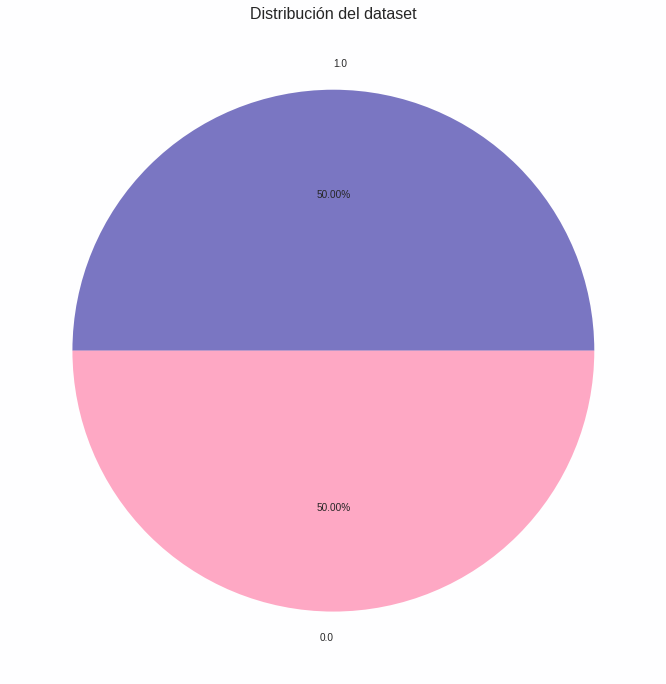

In [52]:
index_count = y_oversample.value_counts().index
values = y_oversample.value_counts().values

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

fig, ax = plt.subplots(figsize=(14,12))
ax.pie(values, labels = index_count, autopct='%1.2f%%')
ax.set_title('Distribución del dataset', fontsize=16)
plt.show()

Dimensiones del dataset tras el tratamiento

In [53]:
print(f' X: {X_oversample.shape}')
print(f' y: {y_oversample.shape}')

 X: (81100, 28)
 y: (81100,)


## Modelo: MLP

Realizamos tamizado de los parámetros mediante [nervergrad](https://facebookresearch.github.io/nevergrad/)


In [56]:
X_train, X_val, y_train, y_val = train_test_split(X_oversample, y_oversample, test_size=0.2, random_state=42)

In [57]:
def create_model(n_capas_dense, d_1, d_2, d_3, d_4, dropout, f_activacion):
    
    input_dim = Input(shape = X_train.shape[1])

    if n_capas_dense >= 1:

        block_1 = BatchNormalization()(input_dim)
        block_1 = Dense(d_1, activation = f_activacion)(block_1)
        block_1 = Dropout(rate=dropout)(block_1)
        output = (block_1)

    if n_capas_dense >= 2:

        block_2 = BatchNormalization()(block_1)
        block_2 = Dense(d_2, activation = f_activacion)(block_2)
        block_2 = Dropout(rate=dropout)(block_2)
        output = (block_2)
 
    if n_capas_dense >= 3:

        block_3 = BatchNormalization()(block_2)
        block_3 = Dense(d_3, activation = f_activacion)(block_3)
        block_3 = Dropout(rate=dropout)(block_3)
        output = (block_3)

    if n_capas_dense >= 4:

        block_4 = BatchNormalization()(block_3)
        block_4 = Dense(d_4, activation = f_activacion)(block_4)
        block_4 = Dropout(rate=dropout)(block_4)
        output = (block_4)

    out = Dense(1, activation='sigmoid')(output)

    model = Model(inputs = input_dim, outputs = out)

    return model

In [58]:
def init_model(n_capas_dense, d_1, d_2, d_3, d_4, dropout, f_activacion):

    model = create_model(n_capas_dense, d_1, d_2, d_3, d_4, dropout, f_activacion)
    
    # callback early stopping
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, min_delta=0.01, patience=15, restore_best_weights = True)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=256, epochs=50, verbose=1, validation_data = (X_val, y_val), callbacks=[es])
    
    score = model.evaluate(X_val, y_val, verbose=0)

    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    return float(score[0])  

In [59]:
n_capas_dense = ng.p.Choice([1, 2, 3, 4])

d_1 = ng.p.TransitionChoice(range(10, 1000, 100))
d_2 = ng.p.TransitionChoice(range(10, 500, 50))
d_3 = ng.p.TransitionChoice(range(10, 250, 25))
d_4 = ng.p.TransitionChoice(range(10, 50, 5))

dropout = ng.p.Scalar(lower=0.0, upper=0.7)

f_activacion = ng.p.Choice(['relu', 'elu', 'tanh'])

params = ng.p.Instrumentation(n_capas_dense, d_1, d_2, d_3, d_4, dropout, f_activacion)
optimizer = ng.optimizers.TwoPointsDE(parametrization=params, budget=50)
best = optimizer.minimize(init_model, batch_mode=False)

Epoch 1/50
254/254 [==============================] - 6s 11ms/step - loss: 0.5237 - accuracy: 0.7635 - val_loss: 2.5846 - val_accuracy: 0.5007
Epoch 2/50
254/254 [==============================] - 2s 10ms/step - loss: 0.4505 - accuracy: 0.7947 - val_loss: 0.4496 - val_accuracy: 0.7843
Epoch 3/50
254/254 [==============================] - 2s 9ms/step - loss: 0.4347 - accuracy: 0.8010 - val_loss: 0.4065 - val_accuracy: 0.8112
Epoch 4/50
254/254 [==============================] - 2s 9ms/step - loss: 0.4237 - accuracy: 0.8069 - val_loss: 0.4021 - val_accuracy: 0.8126
Epoch 5/50
254/254 [==============================] - 2s 9ms/step - loss: 0.4200 - accuracy: 0.8089 - val_loss: 0.4003 - val_accuracy: 0.8114
Epoch 6/50
254/254 [==============================] - 2s 10ms/step - loss: 0.4162 - accuracy: 0.8106 - val_loss: 0.3945 - val_accuracy: 0.8167
Epoch 7/50
254/254 [==============================] - 2s 10ms/step - loss: 0.4135 - accuracy: 0.8140 - val_loss: 0.3911 - val_accuracy: 0.8194
Ep

Valores de los hiperparámetros encontrados tras nervergrad.

In [60]:
best.value

((2, 410, 260, 160, 25, 0.23993369838522638, 'relu'), {})

Creación del modelo MLP con los hiperparámetros encontrados

In [74]:
model = create_model(2, 410, 260, 160, 25, 0.23993369838522638, 'relu')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, min_delta=0.01, patience=15, restore_best_weights = True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_oversample, y_oversample, validation_split=0.3, batch_size=256, epochs=50, verbose=1, callbacks=[es])

Epoch 1/50
222/222 [==============================] - 3s 9ms/step - loss: 0.4092 - accuracy: 0.8164 - val_loss: 16.7647 - val_accuracy: 0.0000e+00
Epoch 2/50
222/222 [==============================] - 2s 7ms/step - loss: 0.3778 - accuracy: 0.8313 - val_loss: 1.7733 - val_accuracy: 0.2676
Epoch 3/50
222/222 [==============================] - 2s 7ms/step - loss: 0.3652 - accuracy: 0.8383 - val_loss: 0.6222 - val_accuracy: 0.6798
Epoch 4/50
222/222 [==============================] - 2s 7ms/step - loss: 0.3610 - accuracy: 0.8391 - val_loss: 0.5654 - val_accuracy: 0.7079
Epoch 5/50
222/222 [==============================] - 2s 7ms/step - loss: 0.3552 - accuracy: 0.8420 - val_loss: 0.5314 - val_accuracy: 0.7233
Epoch 6/50
222/222 [==============================] - 2s 7ms/step - loss: 0.3527 - accuracy: 0.8440 - val_loss: 0.6105 - val_accuracy: 0.6829
Epoch 7/50
222/222 [==============================] - 1s 7ms/step - loss: 0.3501 - accuracy: 0.8430 - val_loss: 0.5430 - val_accuracy: 0.7122
E

Gráficas de 'loss' y 'accuracy' del entrenamiento realizado.

In [78]:
def plot_train_val(history, metric='loss', y_scale='linear'):
    plt.figure(figsize=(12,8))
    plt.plot(history.history[metric], label=metric + ' (train)')
    plt.plot(history.history['val_' + metric], label=metric + ' (val)')
    plt.title(f'{metric} ({y_scale}-scale)')
    plt.xlabel('epoch')
    plt.legend(loc="upper right")
    plt.yscale(y_scale)
    plt.show()

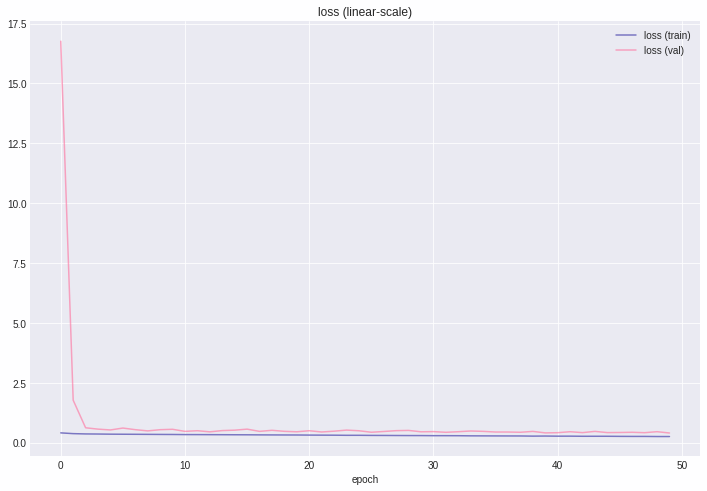

In [79]:
plot_train_val(history) 

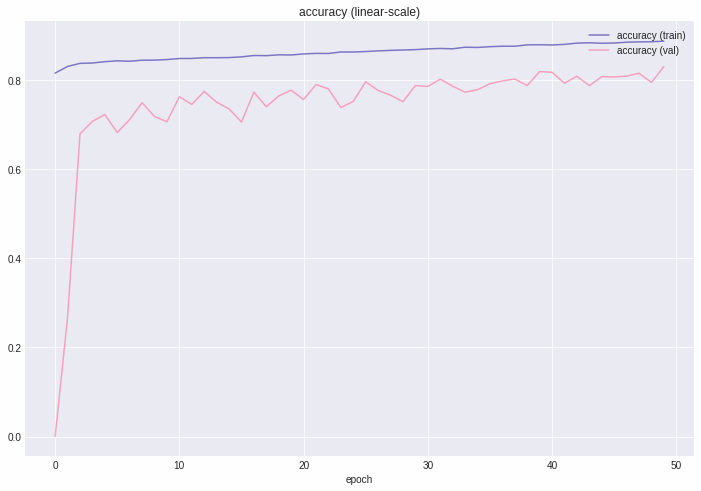

In [80]:
plot_train_val(history, 'accuracy') 

Predicción de los datos del dataset test

In [81]:
output = model.predict(X_test).round()

In [82]:
X_result= pd.DataFrame(output,  columns =['RainTomorrow'])
X_result['id'] = df2['id']
X_result = X_result[['id','RainTomorrow']]

In [83]:
X_result['RainTomorrow'] = X_result['RainTomorrow'].replace({1: 'Yes', 0: 'No'})

In [84]:
X_result

,id,RainTomorrow
0,132547,No
1,119674,No
2,39095,No
3,103060,Yes
4,38495,No
...,...,...
16723,132661,Yes
16724,10463,No
16725,101989,No
16726,78426,No
